<h2 style="text-align: center;">НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ 
<br/>МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ</h2>
</br>
<h3 style="text-align: center;">Кафедра Паровых и Газовых Турбин</h3>

</br>
</br>
</br>
</br>
</br>

<h1 style="text-align: center;">Курсовая работа по курсу:</h1>
<h1 style="text-align: center;">«Паровые и газовые турбины»</h1>

</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: right;">Студент: Бонадыков Никита Михайлович</h5>
<h5 style="text-align: right;">Группа: ТФэ-01-20</h5>

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: center;">Москва 2023</h5>

### Вариант №2

## $\space$ Дано:
* $P_0 = 24 \space МПа $ - Начальное давление
* $t_0 = 555 ^\circ C$ -  Начальная температура
* $P_{пп} = 3.66 \space МПа$ -  Температура промперегрева 
* $t_{пп} = 552 ^\circ C$ -  Давление промперегрева
* $P_{к} = 3.4 \space кПа$ -  Давление в конденсаторе
* $t_{п.в.} = 271^\circ C$ -  Температура питательной воды
* $N_{э} = 840 \space МВт$ -  Электрическая мощность
* $z = 9 \space шт$  Число регенеративных подогревателей
* $d_{р.с.} = 1.2 \space м$  Средний диаметр
* $n = 60 \space C ^{-1}$  Частота вращения ротора турбины
* $H_{0} = (90-110) \space кДж/кг$ -  Располaгаемый теплоперепад
* $\eta_{oi} = 85  \space % $ КПД цилиндров турбины
* $\eta_{мех} = 85  \space % $ Механический КПД турбины
* $\eta_{эг} = 85  \space % $ КПД электрического генератора

In [1]:
#Импорт библиотек
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd 
import Inner_part

In [2]:
#Инициализация всомагательных параметров расчета  
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [3]:
#Дано
electrical_power = 840 * (10 ** 6) # Электрическая мощность    
p0 = 24 * MPa # Начальное давление 
t0 = 555 # Начальная температура 
pk = 3.4 * kPa # Давление в конденсаторе
p_middle = 3.4 * MPa # Давление промперегрева
t_middle = 552 # Температура промперегрева 
p_feed_water = 1.4 * p0 # Давление питательной воды 
t_feed_water = 271 # Температура питательной воды
z = 8 # Число регенеративных подогревателей
internal_efficiency = 0.85 # КПД цилиндров турбины
mechanical_efficiency = 0.992 # Механический КПД турбины
generator_efficiency = 0.99 #КПД электрического генератора
d_sr = 1.2 # Средний диаметр 
n = 60 # Частота вращения ротара турбины 
H0 = np.arange(90,120) # Распологаемый теплоперепад 
p = 0.05 # Степень реактивности 

### Вывод параметров точек процесса расширения пара

In [4]:
point0,point1,point2,point_middle = Inner_part.point_s(p0,t0,p_middle,t_middle,pk,internal_efficiency)       
Inner_part.tab_point(p0,t0,p_middle,t_middle,pk,internal_efficiency)

,point 0,point 1,point middle,point 2
"P, МПа",22.800000,3.740000,3.298000,0.003400
"T, K",823.798877,564.592646,824.731592,299.331624
"h, $\frac{кДж}{кг}$",3366.687307,2946.639584,3570.391748,2393.901027
"S, $\frac{кДж}{кг * K}$",6.250893,6.365060,7.334731,8.014553


### Вывод значений массового расхода

In [5]:
inlet_mass_flow = Inner_part.complite_inlet_mass_flow(p0, t0, p_middle, t_middle, pk, p_feed_water, 
                t_feed_water, internal_efficiency, mechanical_efficiency, generator_efficiency, electrical_power, z)
condenser_mass_flow = Inner_part.complite_condenser_mass_flow(p0, t0, p_middle, t_middle, pk, 
                    p_feed_water, t_feed_water, internal_efficiency, mechanical_efficiency, generator_efficiency, 
                    electrical_power, z)  
Inner_part.tab_flow(p0, t0, p_middle, t_middle, pk, p_feed_water, t_feed_water, internal_efficiency, 
                    mechanical_efficiency, generator_efficiency, electrical_power, z)

,,
Показатель,Массовый расход в турбину на входе,Массовый расход в конденсатор
Параметры,$G_{0}$,$G_{k}$
Значение,660.79696,436.723709


### H-S Диаграмма 

In [6]:
#Inner_part.plot_hs(p0, t0, p_middle, t_middle, pk, internal_efficiency)

In [7]:
Inner_part.data_output(point0, point1, point2, d_sr, n, p, H0[-1], inlet_mass_flow)

Предрасчет сопловой решетки


,Показатель,Параметр,Значение
0,Теплоперепад в сопловой решётке,$H_{0c} \space \frac{кДж}{кг}$,113.000
1,Теплоперепад в рабочей решётке,$H_{0p} \space \frac{кДж}{кг}$,6.000
2,Теоретическая абсолютная скорость на выходе из...,"$c_{1t}, \space \frac{м}{с}$",475.500
3,Скорость звука на выходе из сопловой решётки,"$a_{1t}, \space \frac{м}{с}$",647.034
4,Число Маха на выходе из сопловой решётки,$M_{1t}$,0.735
5,Предварительная площадь выхода потока из сопло...,"$F_{1}, \space м^{2}$",0.026


Подходячий тип сопловой решетки C-90-12A


,Показатель,Параметр,Значение
0,Угол выхода потока из решётки,"$\alpha_{1э}$, град",10 - 14
1,Угол входа в решётку,"$\alpha_{0расч}$, град",70 - 119
2,Оптимальный шаг решётки,$t_{отн}$,0.72 - 0.88
3,Максимальное допустимое число Маха,$M_{1t}$,0.85
4,"Хорда сопловой решётки, мм","$b_{1}$, мм",62.5
5,"Площадь поперечного сечения сопловой решётки, ...","F, $см^{2}$",4.09
6,Момент инерции сопловой решётки,"$I_{min}, см^{4}$",0.591
7,Момент сопротивления сопловой решётки,"$W_{min}$, $см^{3}$",0.575


Расчет дополнительных параметров сопловой решетки


,Показатель,Параметр,Значение
0,Произведение el1,"$el_{1}, м$",0.030256
1,Оптимальное значение степени парциальности,$e_{opt}$,0.695773
2,Высота сопловых лопаток,"$l_{1}$, м",0.043486
3,Уточняем коэффициент расхода сопловой решетки,$\mu_{1}$,0.974814
4,Количество лопаток в сопловой решетке,$z_{1}$,52.000000
5,Уточненый оптимальный относительный шаг,$t_{1}$,0.807077


Расчет параметров сопловой решетки из аталаса


,Показатель,Параметр,Значение
0,Угол установки профиля решётки,"$\alpha_{уст}, град$",33.200000
1,Отношение: b1/l1,"$\frac{b_{1}}{l_{1}}$, м",1.437000
2,Коэффициент профильных потерь,$\xi_{проф}$,0.020000
3,Коэффициент суммарных потерь,$\xi_{сум}$,0.044000
4,Коэффициент концевых потерь,$\xi_{конц}$,0.024000
5,Коэффициент скорости сопловой решетки,$\phi$,0.977753
6,Скорость выхода пара из сопловой решетки,$c_{1} \frac{м}{с}$,464.921069
7,Реальный угол выхода потока из сопловой решётки,"$\alpha_{1}, град$",12.960245


Предрасчет рабочей решетки


,Показатель,Параметр,Значение
0,Относительная скорость на выходе из сопловой р...,$W_{1} \space \frac{м}{с}$,249.696093
1,Угол направления относительной скорости потока...,"$\beta_{1}, град$",24.682413
2,Теоретическая относительная скорость на выходе...,"$w_{2t}, \space \frac{м}{с}$",272.485117
3,Высота рабочих лопаток,"$l_{2}, м$",0.047486
4,Скорость звука за рабочей решеткой (теоретичес...,"$a_{2t}, \space \frac{м}{с}$",623.309929
5,Теоретическое число Маха за рабочей решёткой,$M_{2t}$,0.437158
6,Потери в сопловой решетке,$\Delta H_{c} \frac{кДж}{кг}$,4.974200


Подходячий тип рабочей решетки P-23-14A


,Показатель,Параметр,Значение
0,Угол выхода потока из решётки,"$\beta_{2э}$, град",11 - 15
1,Угол входа в решётку,"$\beta_{1расч}$, град",20 - 29
2,Оптимальный шаг решётки,$t_{отн}$,0.6 - 0.75
3,Максимальное допустимое число Маха,$M_{2t}$,0.95
4,"Хорда сопловой решётки, мм","$b_{2}$, мм",25.9
5,"Площадь поперечного сечения сопловой решётки, ...","F, $см^{2}$",2.44
6,Момент инерции сопловой решётки,"$I_{min}, см^{4}$",0.43
7,Момент сопротивления сопловой решётки,"$W_{min}$, $см^{3}$",0.39


Расчет дополнительных параметров рабочей решетки


,Показатель,Параметр,Значение
0,Коэффициент расхода рабочей решётки,$\mu_{2}$,0.959546
1,Выходная площадь рабочей решётки,$F_{2} \space м^{2}$,0.046144
2,Эффективный угол выхода потока из рабочей решётки,"$\beta_{2e}, град$",21.226259
3,Количество лопаток в рабочей решётке,$z_{2}$,216.000000
4,Оптимальный шаг рабочей решётки,$t_{2opt}$,0.675000
5,Угол установки рабочих лопаток,"$\beta_{уст}, град$",85.107509
6,Отношение $\frac{b_{2}}{l_{2}}$,$\frac{b_{2}}{l_{2}}$,0.545426


Расчет параметров рабочей решетки из аталаса


,Показатель,Параметр,Значение
0,Коэффициент профильных потерь в решётке,$\xi_{проф}$,0.055000
1,Коэффициент суммарных потерь,$\xi_{сум}$,0.098000
2,Коэффициент концевых потерь,$\xi_{конц}$,0.043000
3,Коэффициент скорости рабочей решётки,$\phi$,0.949737
4,Угол направления относительной скорости на вых...,"$\beta_{2}, град$",21.456277
5,Абсолютная скорость на выходе из рабочей решётки,"$c_{2}, \space \frac{м}{с}$",95.791146
6,Угол выхода абсолютной скорости из рабочей реш...,"$\alpha_{2}, град$",81.197025
7,Действительная относительная скорость на выход...,"$w_{2}, \space \frac{м}{с}$",258.789144


D:\PYTON\PythonTurbine\Курсач\Inner_part.py:821: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(15, 5))


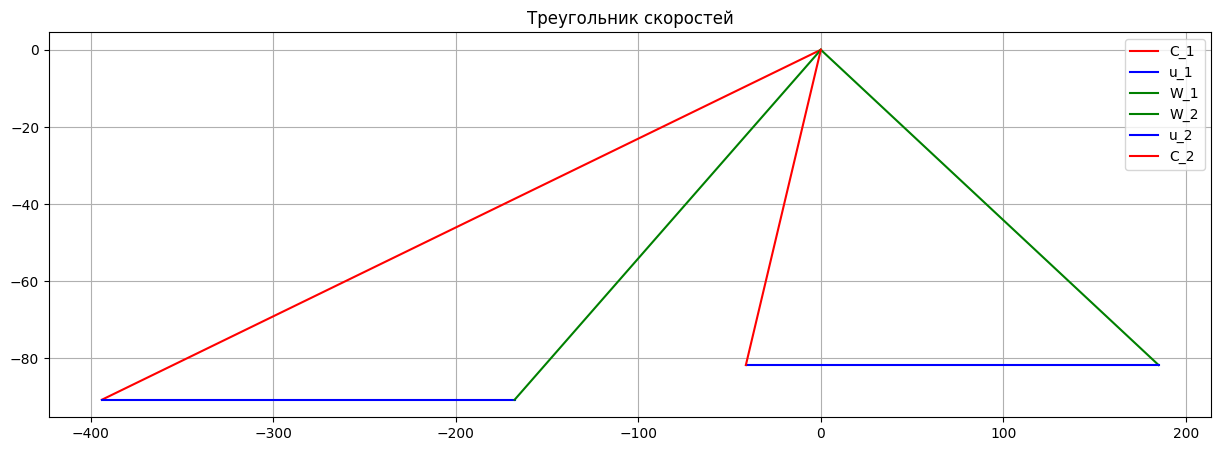

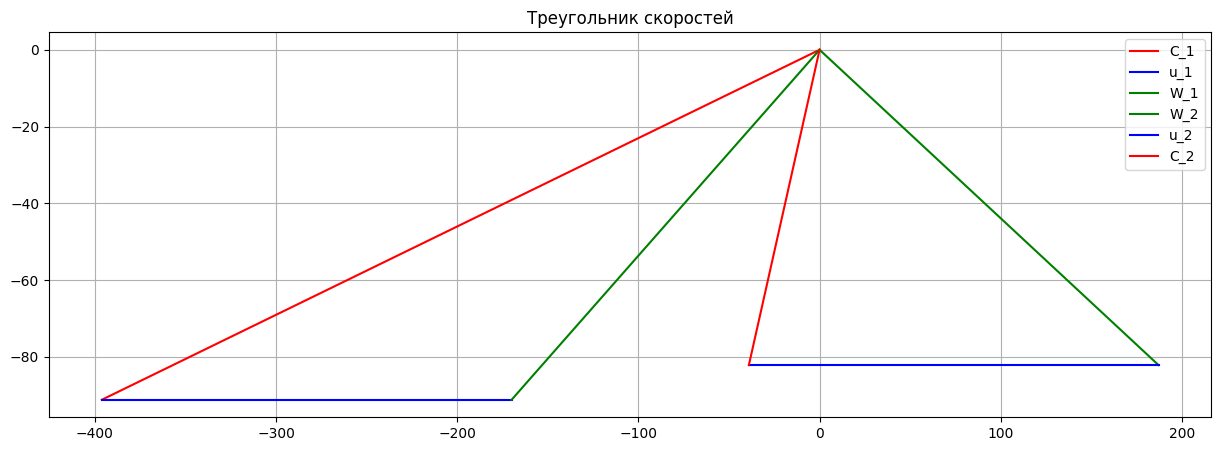

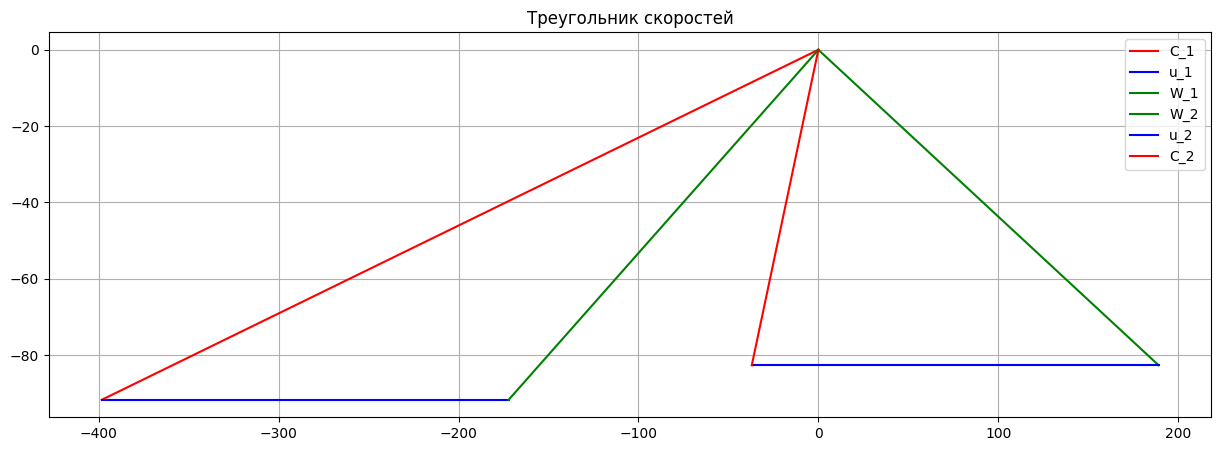

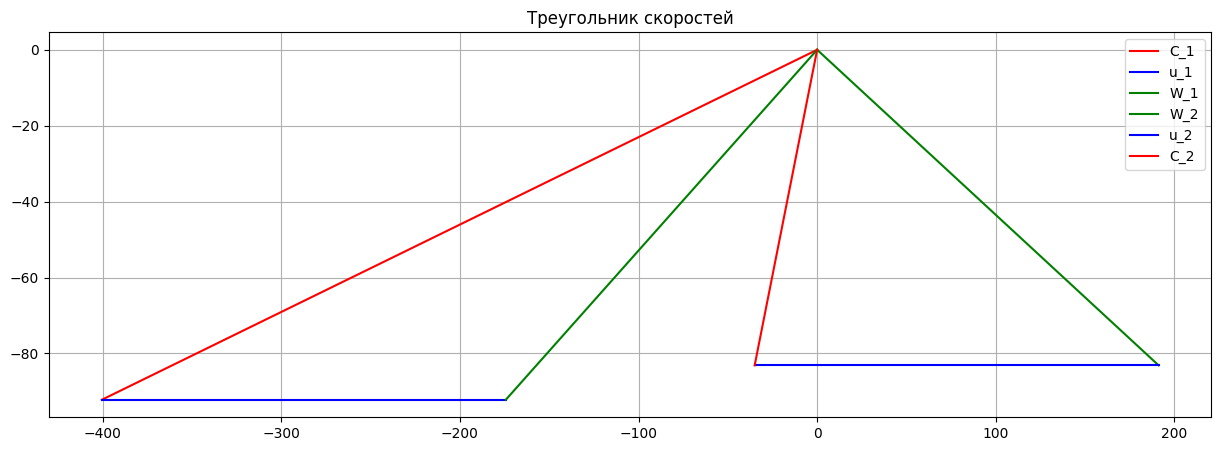

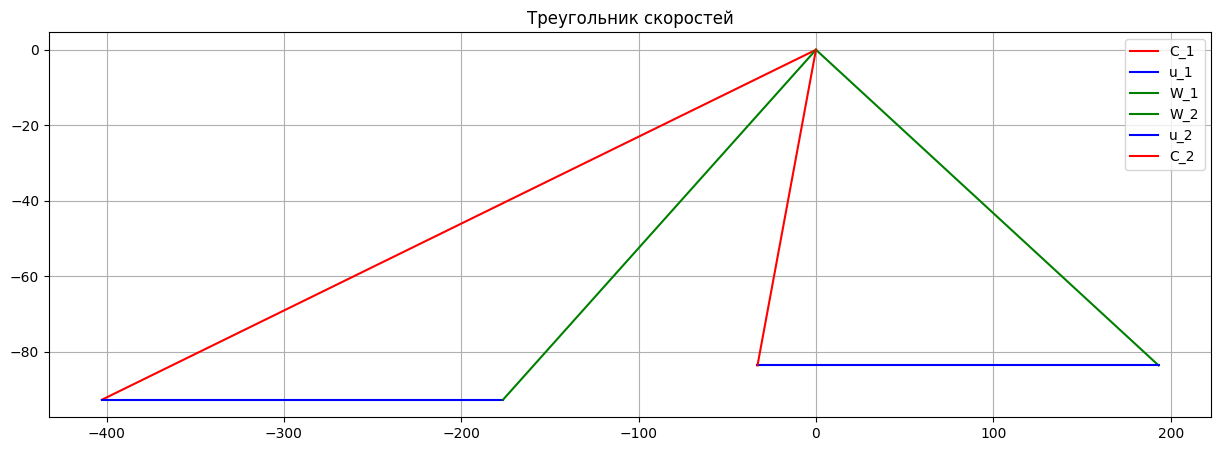

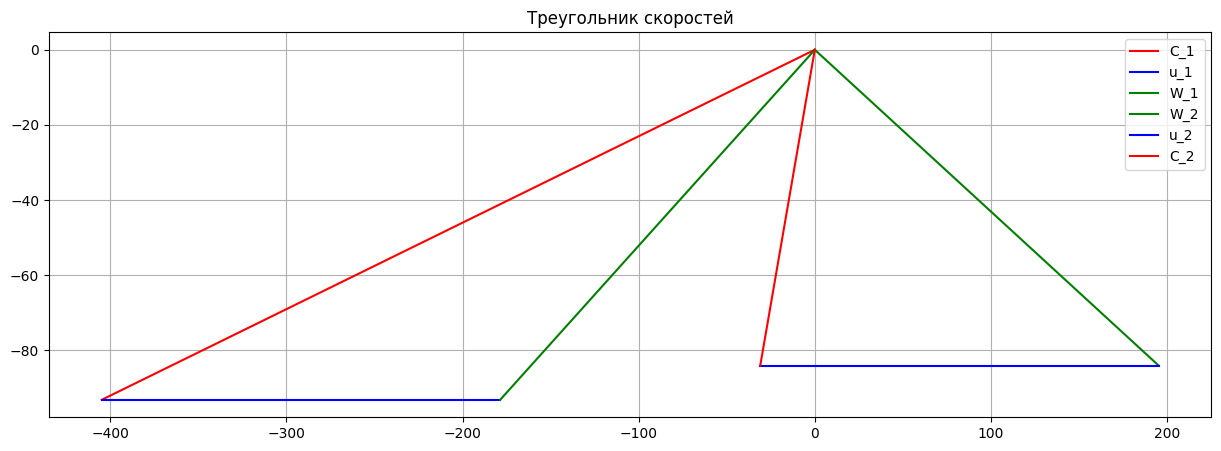

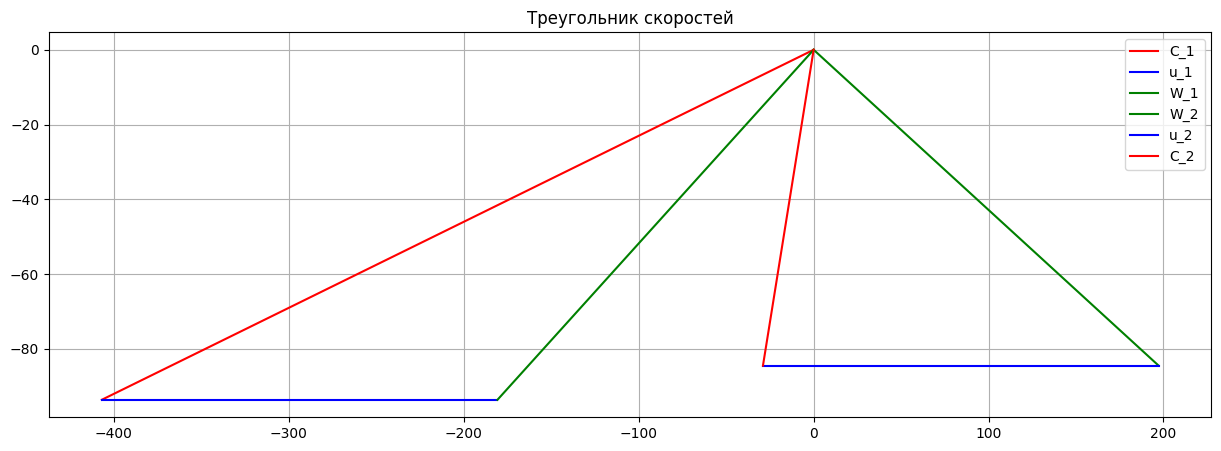

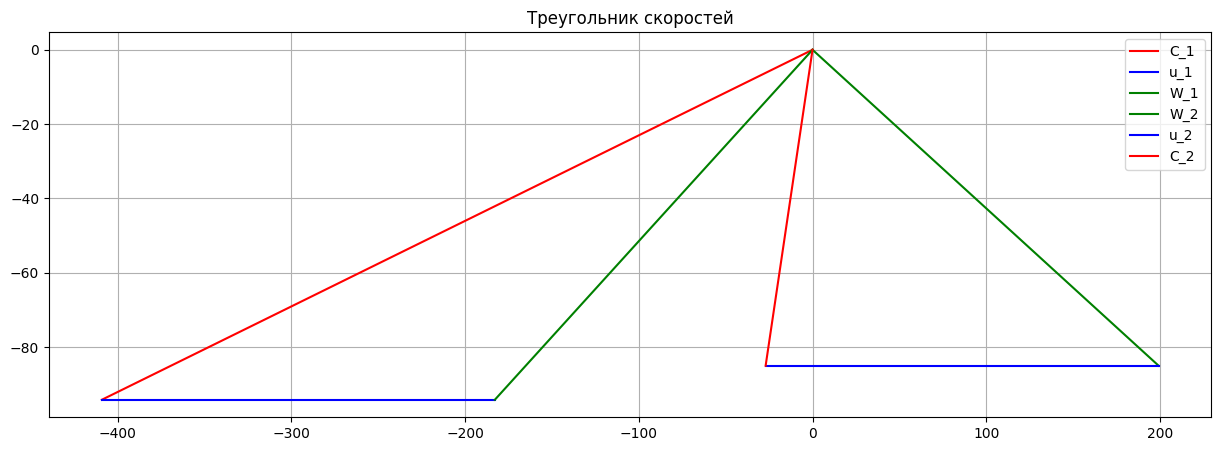

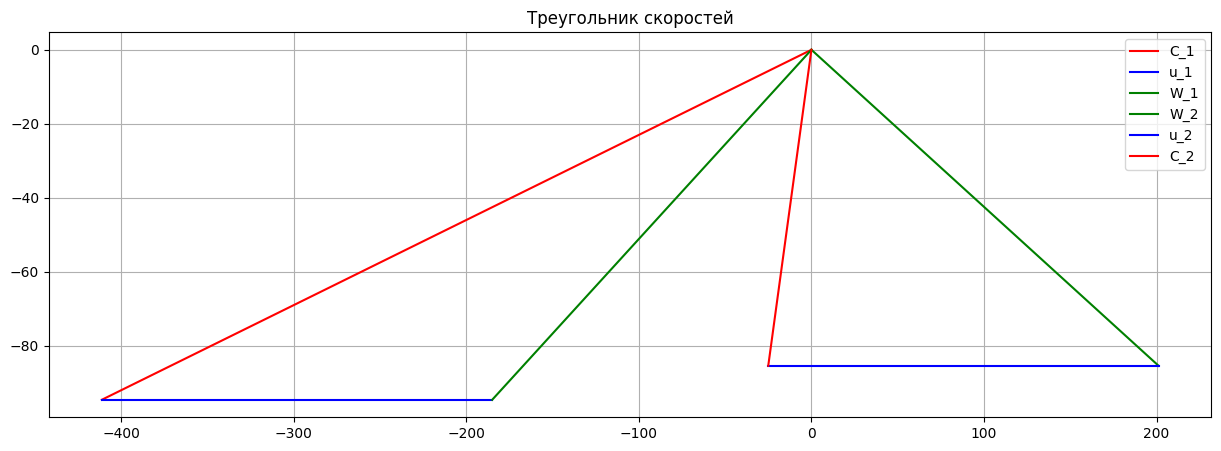

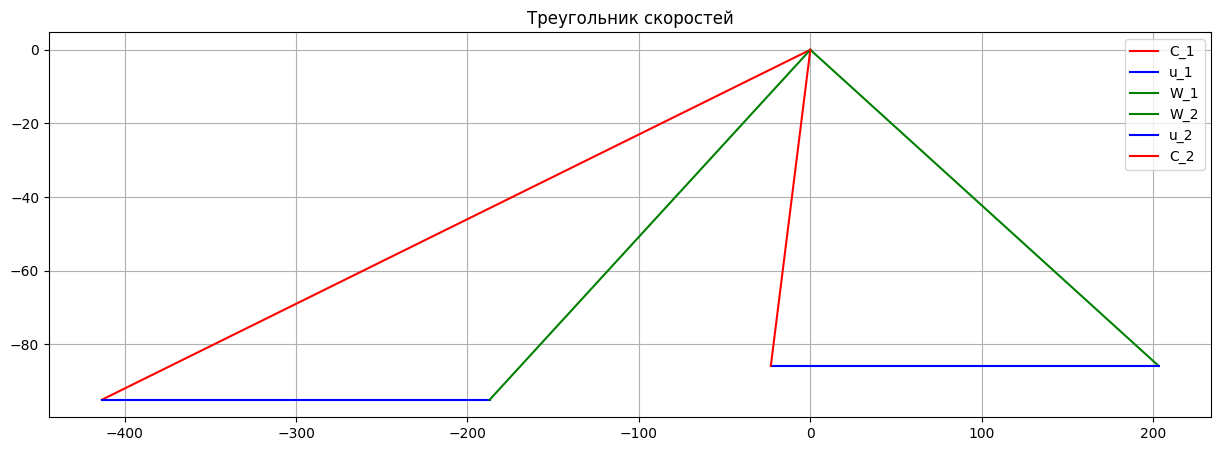

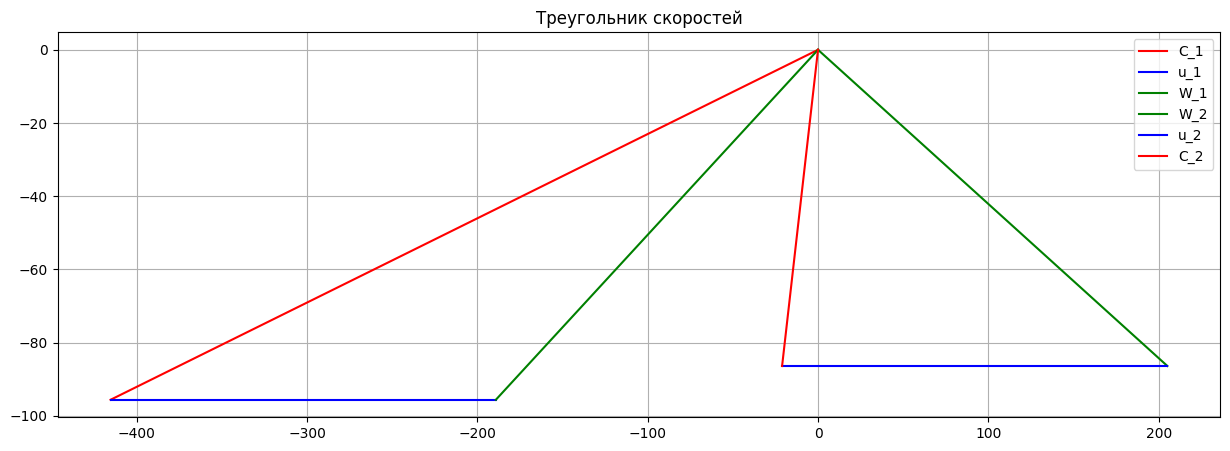

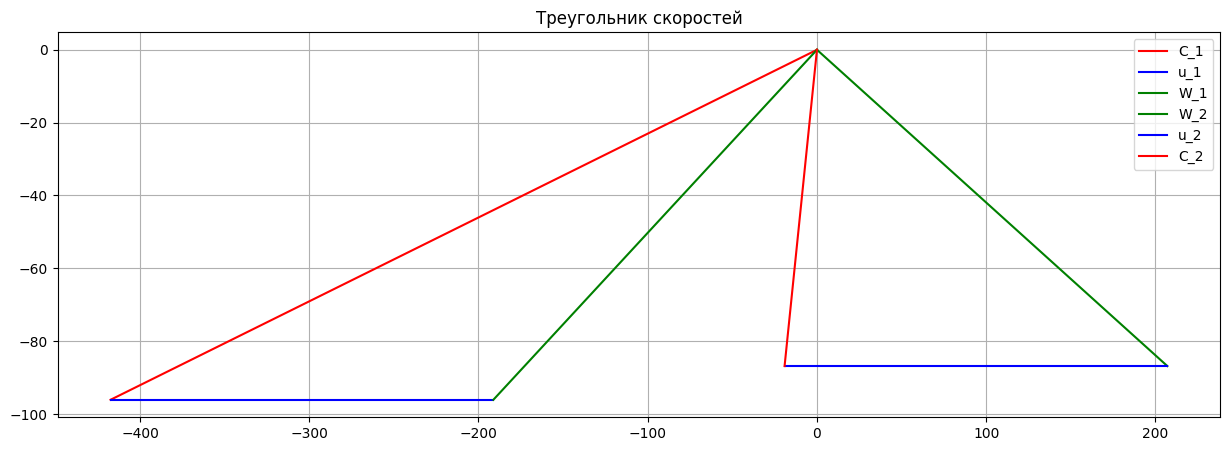

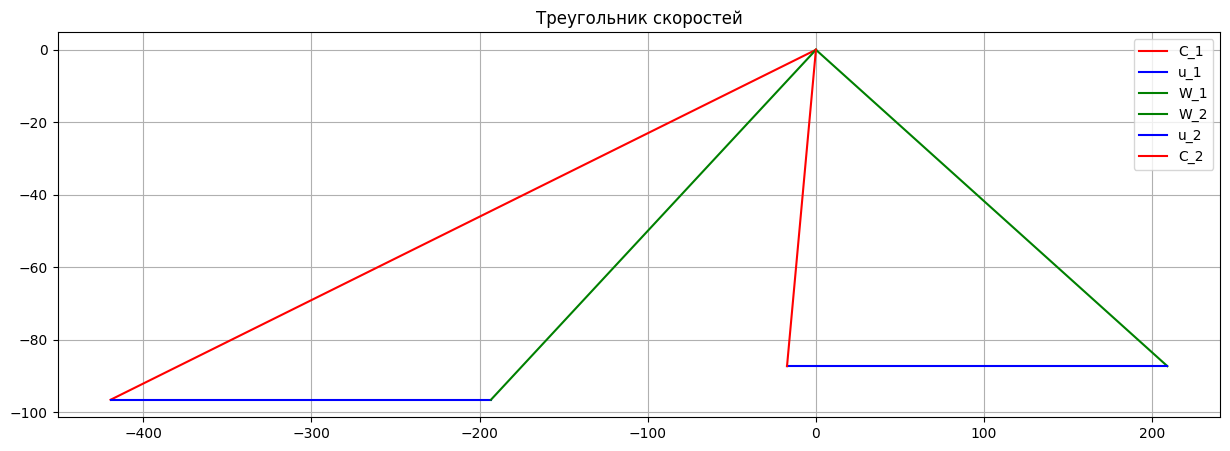

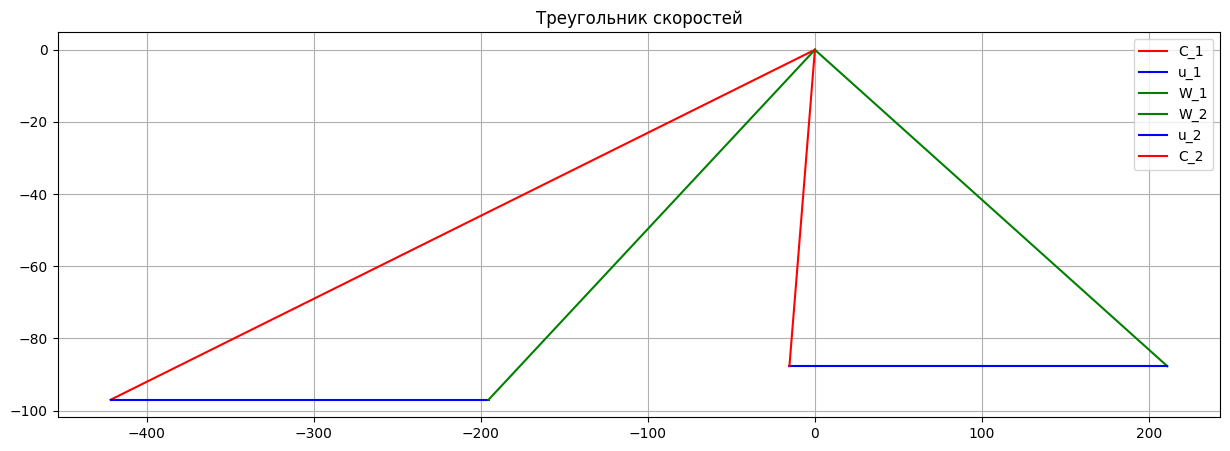

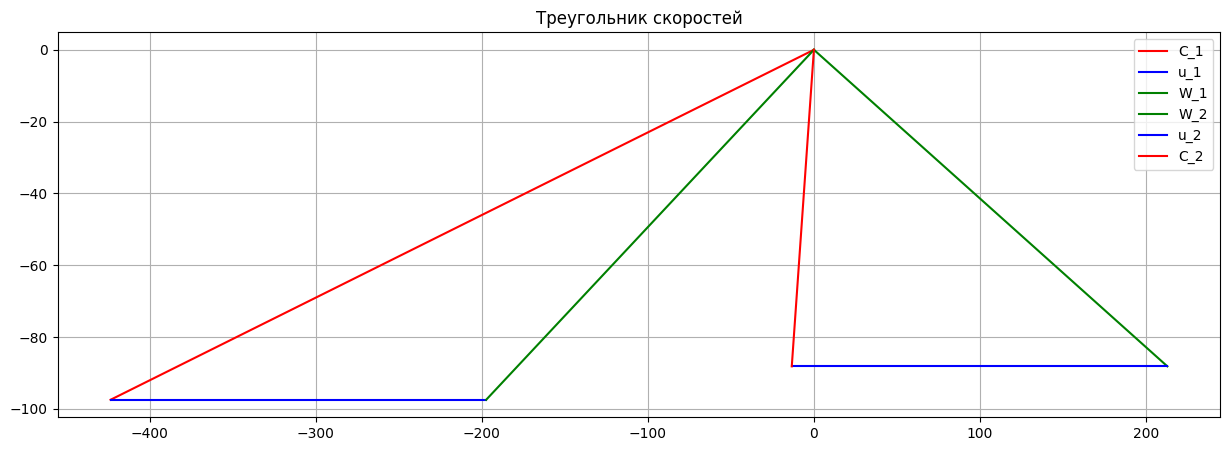

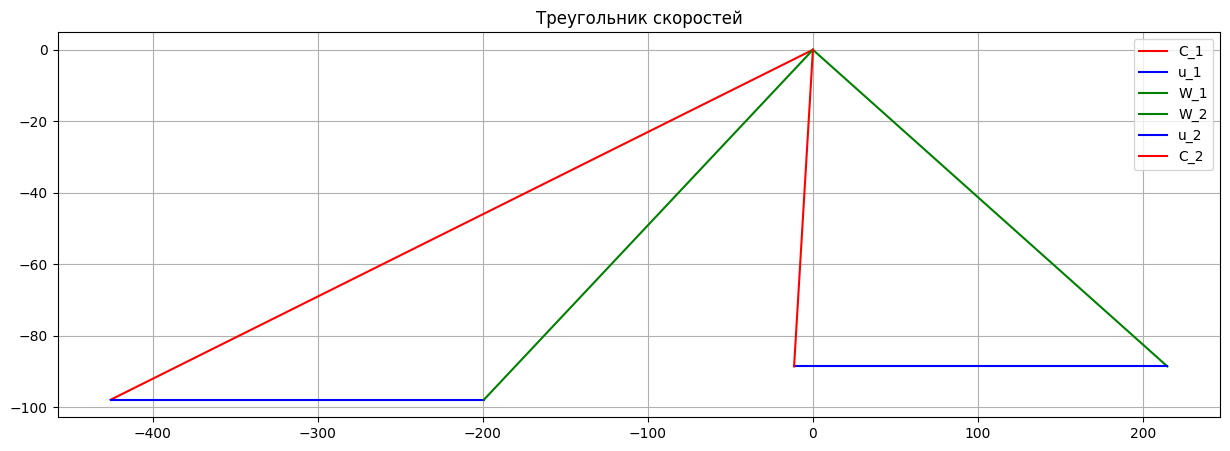

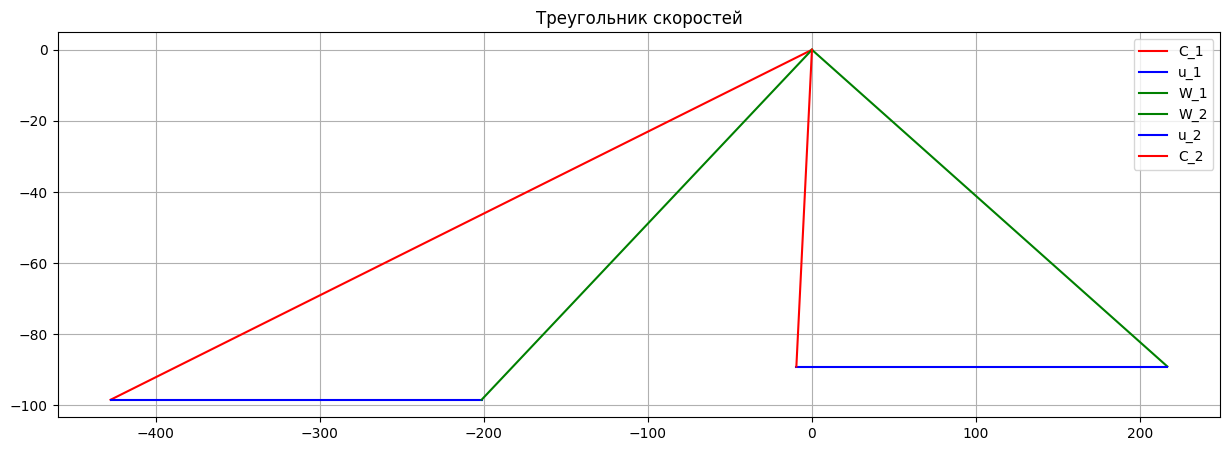

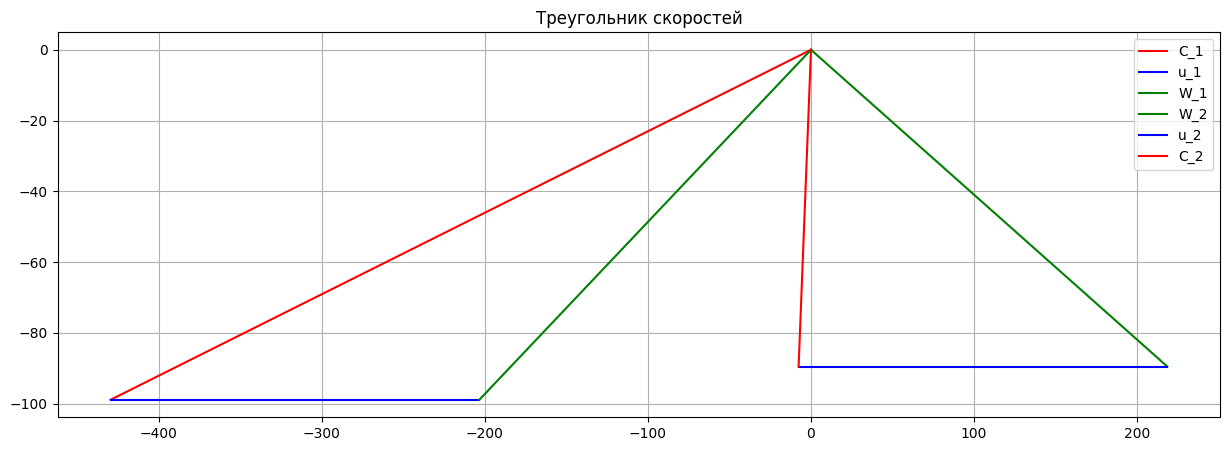

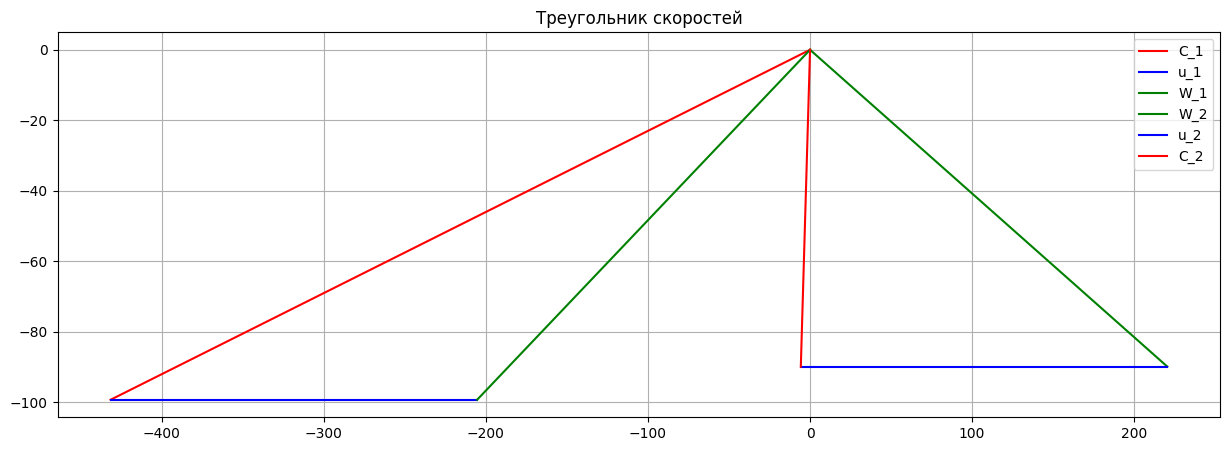

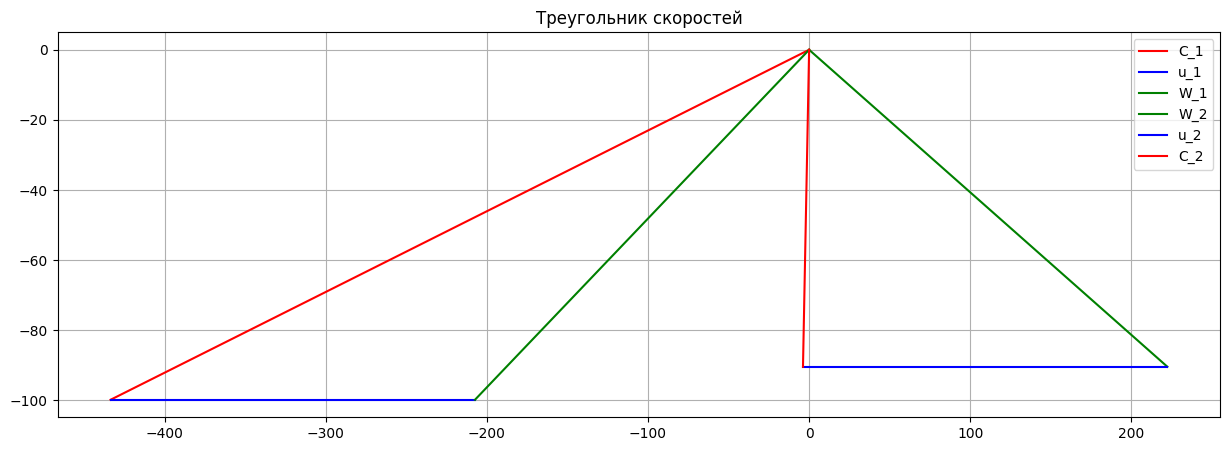

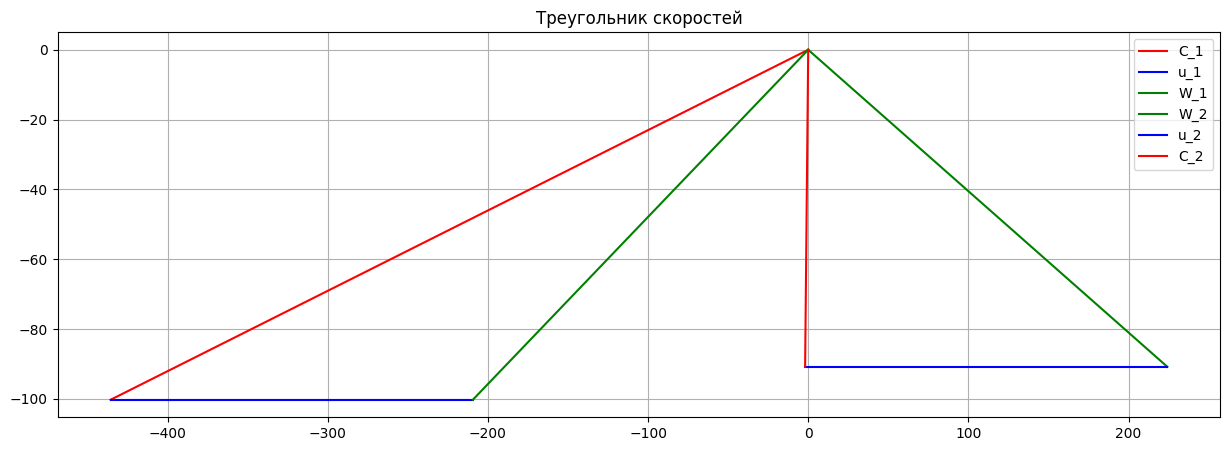

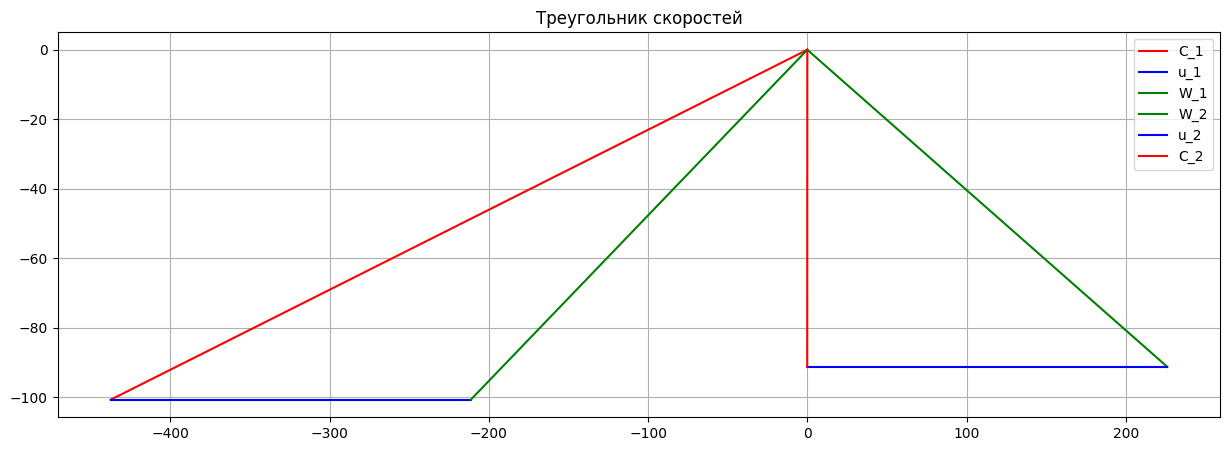

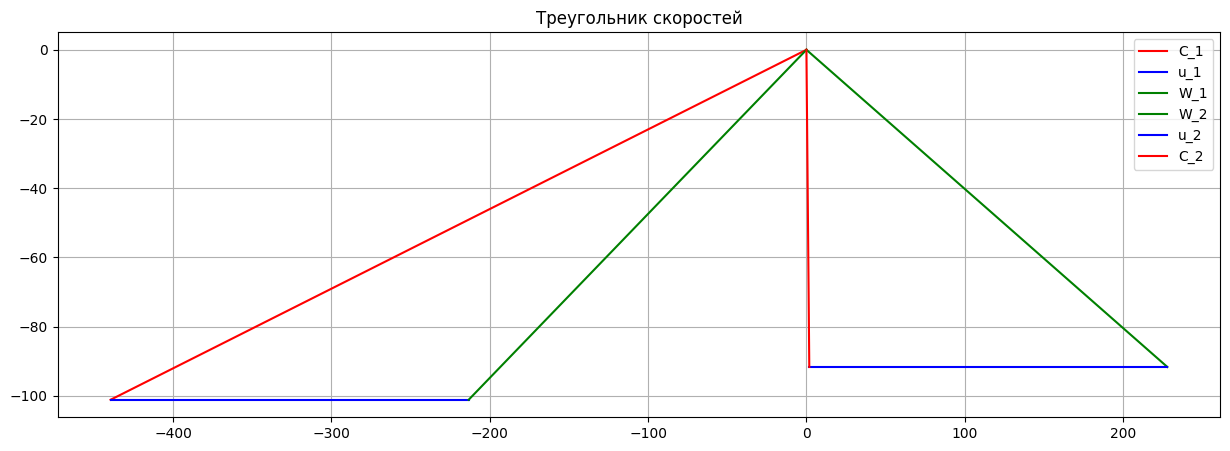

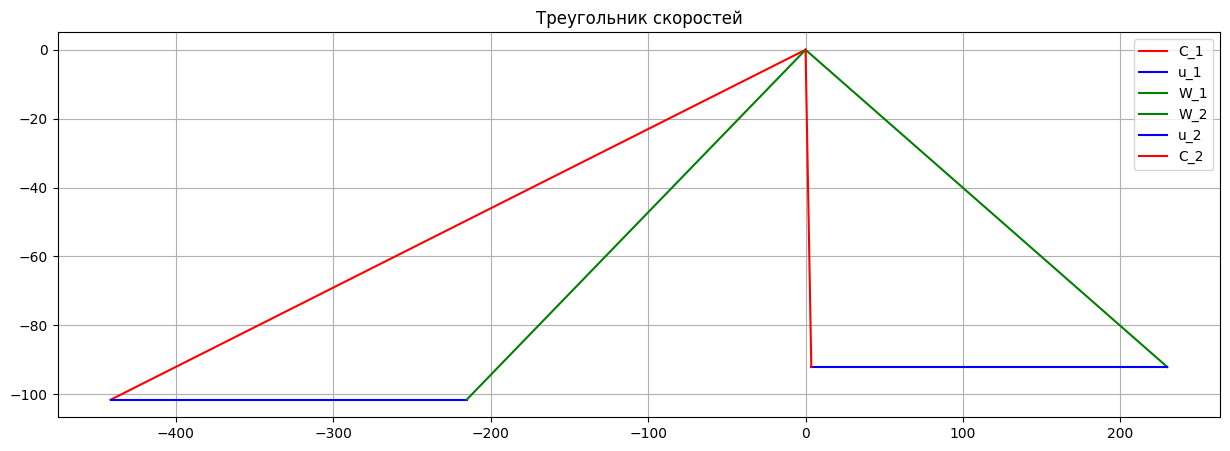

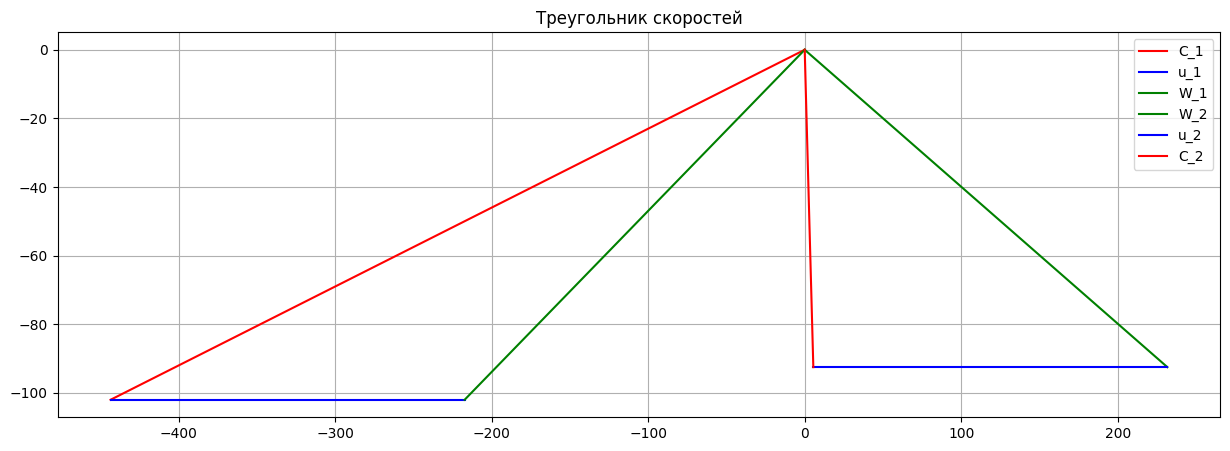

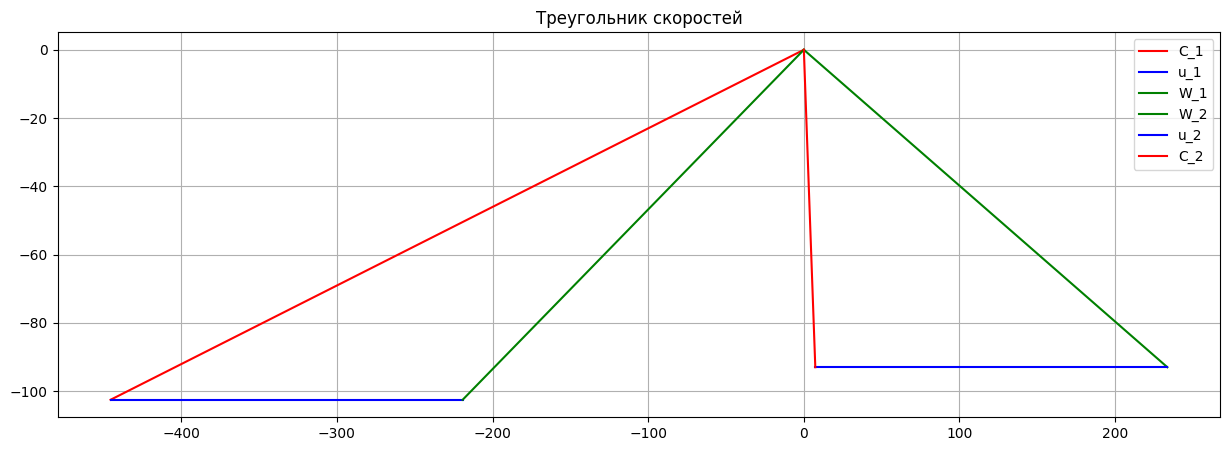

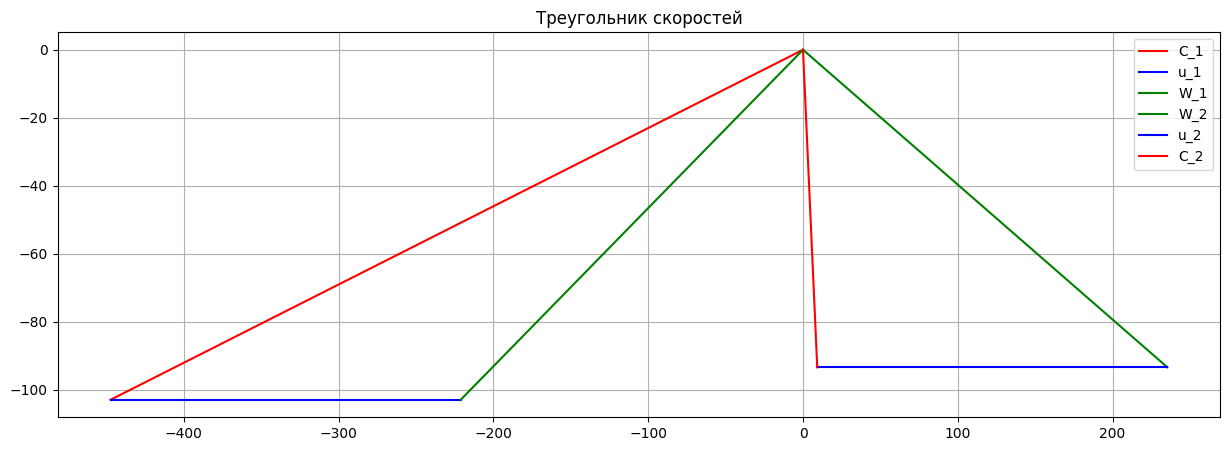

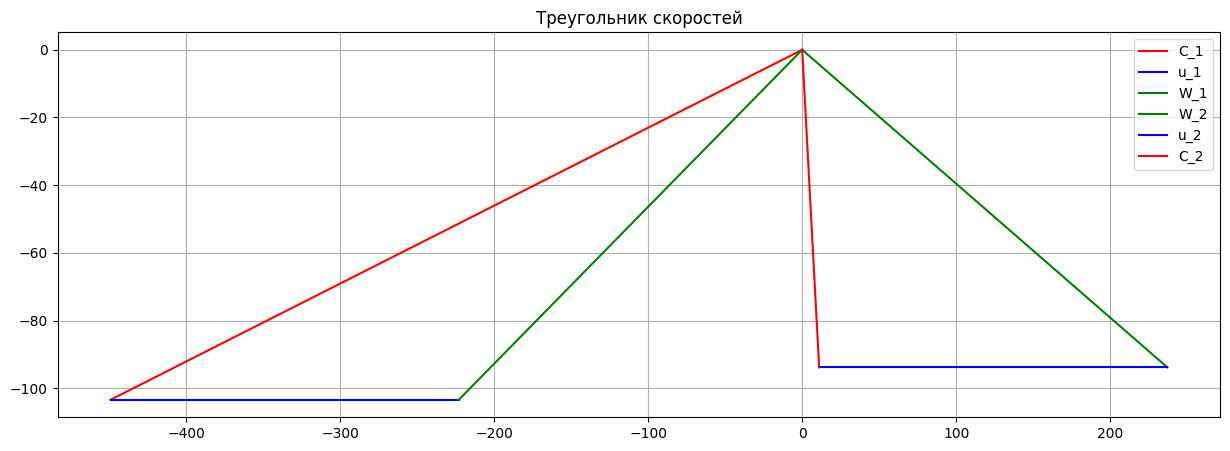

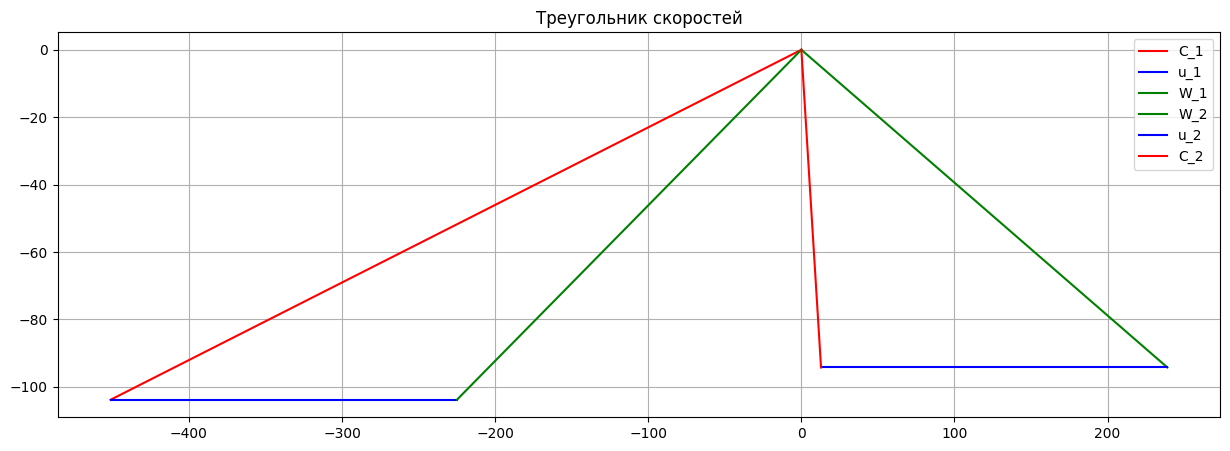

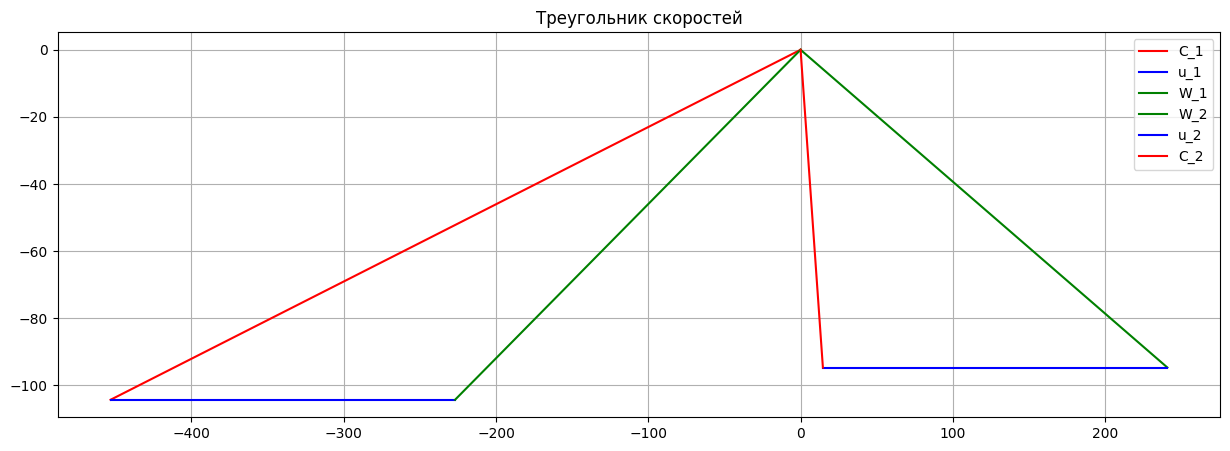

In [8]:
for i in H0:
    Inner_part.plot_triangles(point0, d_sr, n, p, i, inlet_mass_flow)

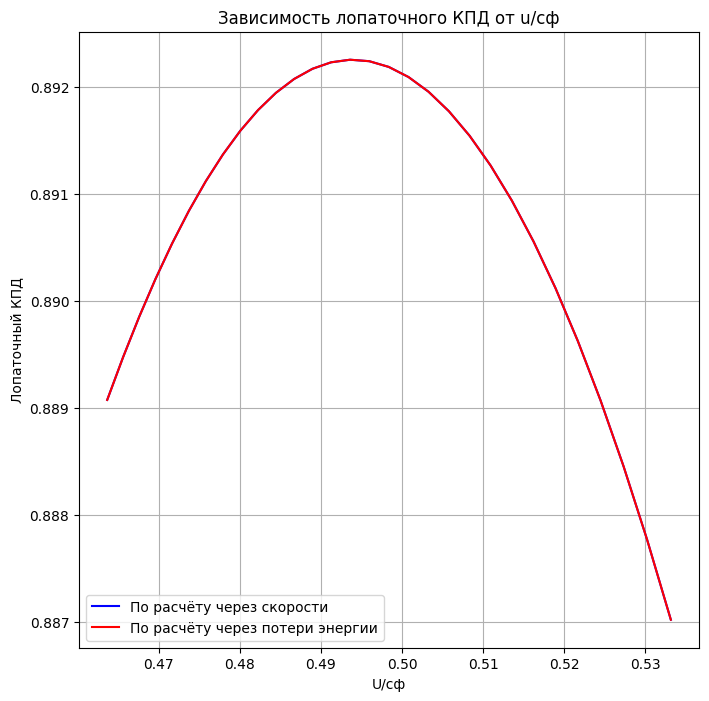

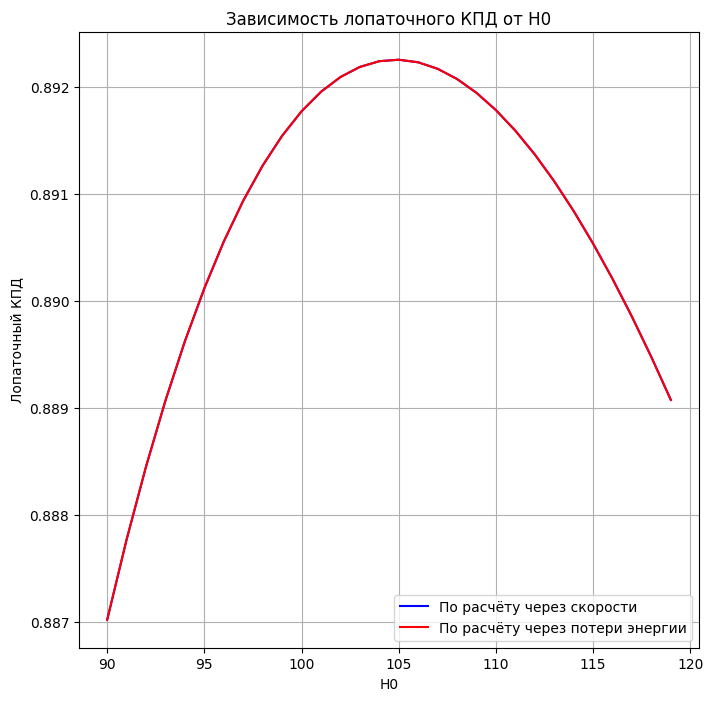

In [9]:
Inner_part.efficiency_graph(point0, d_sr, n, p, H0, inlet_mass_flow)